In [1]:
import tszip

# install sc2ts using python -m pip install git+https://github.com/jeromekelleher/sc2ts
# where python is the python running in your jupytyer notebook (find this by
# import sys; print(sys.executable)
import sc2ts

ts = tszip.decompress(f"../data/upgma-mds-1000-md-30-mm-3-2022-06-30-recinfo-il.ts.tsz")  # long ARG
# or use ts = tszip.decompress(f"data/upgma-full-md-30-mm-3-2021-06-30-recinfo-il.ts.tsz")  # wide ARG

treeinfo = sc2ts.TreeInfo(ts)

# Setup reporting (this is a bit of a jupyter hack)
def report(*args, **kwargs):
    display(*treeinfo.node_report(*args, **kwargs))


Classifying mutations: 100%|██████████| 1062072/1062072 [00:23<00:00, 44492.64it/s]


In [2]:
def variant_name(pango):
    """
    Classification from the following site
    https://www.cdc.gov/coronavirus/2019-ncov/variants/variant-classifications.html
    Alpha (B.1.1.7 and Q lineages)
    Beta (B.1.351 and descendent lineages)
    Gamma (P.1 and descendent lineages)
    Delta (B.1.617.2 and AY lineages)
    Epsilon (B.1.427 and B.1.429)
    Eta (B.1.525)
    Iota (B.1.526)
    Kappa (B.1.617.1)
    Mu (B.1.621, B.1.621.1)
    Zeta (P.2)
    Omicron (B.1.1.529, BA.1, BA.1.1, BA.2, BA.3, BA.4 and BA.5 lineages)
    """
    if pango == "B.1.1.7" or pango.startswith("Q"):
        return("Alpha")
    if pango.startswith("B.1.351"):
        return "Beta"
    if pango == "P.1" or pango.startswith("P.1."):
        return "Gamma"
    if pango.startswith("AY") or pango == "B.1.617.2":
        return("Delta")
    if pango == "B.1.427" or pango == "B.1.429":
        return "Epsilon"
    if pango == "B.1.526":
        return "Iota"
    if pango == "B.1.617.1":
        return "Kappa"
    if pango == "B.1.621" or pango == "B.1.621.1":
        return "Mu"
    if pango == "P.2" or pango.startswith("P.2."):
        return "Zeta"
    if pango == "B.1.1.529" or pango.startswith("BA."):
        return "Omicron"
    return("")


In [4]:
# Get pandas dataframe about recombination breakpoints
df = treeinfo.export_recombination_node_breakpoints()

# filter out where max_num_descendants == 1 and where the reported HMM breakpoint has vanished from the ARG
df = df[df.max_descendant_samples > 1]
df = df[df.in_arg == True]

# restrict to only Delta-Delta breakpoints
parent_variants = [
    {variant_name(row.left_parent_pango), variant_name(row.right_parent_pango)}
    for row in df.itertuples()
]

delta_delta_df = df[[v=={"Delta", "Delta"} for v in parent_variants]]

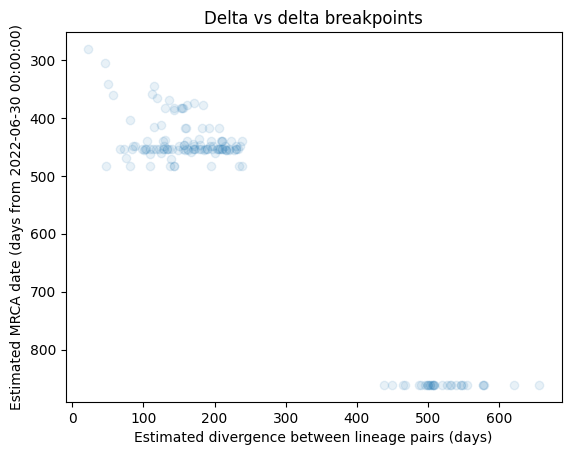

In [22]:
from matplotlib import pyplot as plt
plt.scatter(delta_delta_df.tmrca_delta, delta_delta_df.tmrca, alpha=0.1)
plt.gca().invert_yaxis()
plt.title("Delta vs delta breakpoints")
plt.xlabel("Estimated divergence between lineage pairs (days)")
plt.ylabel(f"Estimated MRCA date (days from {sc2ts.last_date(ts)})")
plt.show()

In [13]:
# Further restrict to all with trmca > 700 days before basetime (basetime = 2021-06-30 for long ts)
delta_delta_old_df = delta_delta_df[delta_delta_df.tmrca > 700]
delta_delta_old_df.sort_values(by=['max_descendant_samples'], ascending=False)

,in_arg,node,max_descendant_samples,breakpoint,hmm_consistent,left_parent,left_parent_pango,right_parent,right_parent_pango,parents_mrca,tmrca,tmrca_delta,nodes_between_parents,origin_nextclade_pango
970,True,349664,39,15451,False,348267,B.1.617.2,348769,B.1.617.2,179,861.0,495.20000,29,B.1.617.2
963,True,347423,24,16466,False,341687,B.1.617.2,341507,B.1.617.2,179,861.0,490.00000,28,B.1.617.2
1074,True,371564,24,15451,False,360067,B.1.617.2,325724,B.1.617.2,179,861.0,507.00000,20,B.1.617.2
1055,True,366069,9,9053,False,344223,B.1.617.2,348650,B.1.617.2,179,861.0,498.20000,27,B.1.617.2
1000,True,355492,8,19220,True,251840,B.1.617.2,277952,B.1.617.2,179,861.0,437.57500,27,B.1.617.2
1613,True,557043,7,22992,False,545252,B.1.617.2,456733,AY.44,5868,860.5,656.30000,31,B.1.617.2
1090,True,383866,6,1334,False,357763,AY.103,361358,AY.44,179,861.0,507.60000,25,AY.44
1172,True,413436,6,4181,True,301081,AY.4,410653,AY.9,179,861.0,549.40000,38,AY.9
1051,True,365268,6,9891,False,305452,AY.25,358318,AY.9.2,179,861.0,505.20000,35,B.1.617.2
1286,True,461115,5,2911,False,329190,AY.4,441464,AY.26,179,861.0,577.20000,39,AY.26


In [19]:
# report on the one with the most descendants, to have a look
print(f"causal strain resulting in 349664 is '{ts.node(349664).metadata['match_info'][1]['strain']}'")
report(349664)

causal strain resulting in 349664 is 'SouthAfrica/NICD-N10586/2021'


# Report for 349664

[{'Imputed_lineage': 'Recombinant',
  'date_added': '2021-06-30',
  'match_info': [{'breakpoints': [0, 10030, 29904],
    'direction': 'backward',
    'mutations': ['4181T>G', '13216T>C', '21618G>C', '29402T>G'],
    'num_mismatches': 3.0,
    'parents': [279458, 348769],
    'strain': 'SouthAfrica/NICD-N10586/2021'},
   {'breakpoints': [0, 15451, 29904],
    'direction': 'forward',
    'mutations': ['5694C>T', '13216T>C', '21618G>C', '29402T>G'],
    'num_mismatches': 3.0,
    'parents': [348267, 348769],
    'strain': 'SouthAfrica/NICD-N10586/2021'}]}]

### Node data 

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,role,branch_length
0,349664,Added 2021-06-30,Recombinant,2,3,39,2021-06-30,-18808 days,----,0,0,0,3,3,Child,0.000000
1,348267,India/AP-CCMB-CIA5941/2021,B.1.617.2,1,2,37,2021-06-29,24 days,1000,5,5,0,5,3,Parent,0.200000
2,348769,Overlap 1 mut 2 sibs,B.1.617.2,1,4,66,2021-06-19,-18797 days,----,1,0,0,5,0,Parent,10.466667


### Edges

id,left,right,parent,child,metadata
0,0,15451,348267,349664,
1,15451,29904,348769,349664,


### Copying pattern

pos,884,6402,7124,8986,9053,10029,15451,19220,23604,28271,28916,29742
ref,C,C,C,C,G,C,G,C,C,A,G,G
P0,C,T,T,T,T,T,A,T,C,T,T,G
C,C,T,T,T,T,T,G,C,G,A,G,T
P1,T,C,C,C,G,C,G,C,G,A,G,T
mut,,,,,,,,,,,,


## Left path to root

### Closest recombinant: 349664

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,349664,Added 2021-06-30,Recombinant,2,3,39,2021-06-30,-18808 days,----,0,0,0,0.200000
1,348267,India/AP-CCMB-CIA5941/2021,B.1.617.2,1,2,37,2021-06-29,24 days,1000,5,5,0,71.792188
2,281795,Added 2021-05-05,B.1.617.2,1,18,60,2021-04-19,-18736 days,----,1,0,0,16.792188
3,261771,Push 1 reversions,B.1.617.2,1,107,174650,2021-04-02,-18719 days,----,1,1,0,3.215625
4,242933,Added 2021-04-03,Recombinant,1,1,174650,2021-03-30,-18716 days,----,0,0,0,3.200000
5,243149,Push 7 reversions,Recombinant,1,6,177633,2021-03-26,-18712 days,----,14,0,0,7.000000
6,248215,Overlap 1 mut 2 sibs,Recombinant,1,2,177638,2021-03-19,-18705 days,----,1,0,0,7.000000
7,235293,Added 2021-03-28,Recombinant,2,4,177649,2021-03-12,-18698 days,----,0,0,0,253.000000
8,21605,SouthAfrica/KRISP-0458/2020,B.1.1,1,1,177293,2020-07-02,21 days,0000,2,0,0,12.000000
9,21606,Added 2020-07-02,B.1.1,1,1,177293,2020-06-20,-18433 days,----,0,0,0,13.750000


## Right path to root

### Closest recombinant: 349664

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,349664,Added 2021-06-30,Recombinant,2,3,39,2021-06-30,-18808 days,----,0,0,0,10.466667
1,348769,Overlap 1 mut 2 sibs,B.1.617.2,1,4,66,2021-06-19,-18797 days,----,1,0,0,4.266667
2,341511,Added 2021-06-23,B.1.617.2,1,7,122,2021-06-15,-18793 days,----,1,1,0,0.533333
3,345304,Push 1 reversions,B.1.617.2,1,13,340,2021-06-14,-18792 days,----,2,1,0,3.733333
4,341512,Added 2021-06-23,B.1.617.2,1,11,370,2021-06-11,-18789 days,----,1,1,0,3.200000
5,322711,SouthAfrica/NICD-N8850/2021,B.1.617.2,1,9,379,2021-06-07,20 days,1000,2,2,0,58.210000
6,322712,Added 2021-06-07,B.1,1,1,379,2021-04-10,-18727 days,----,0,0,0,15.272187
7,322884,Push 2 reversions,B.1,1,15,13081,2021-03-26,-18712 days,----,5,5,0,5.037812
8,235197,Added 2021-03-28,B.1.617.2,1,1,13081,2021-03-21,-18707 days,----,0,0,0,2.283125
9,235719,Push 2 reversions,B.1.617.2,1,8,15578,2021-03-19,-18705 days,----,1,1,0,0.088184


### Children 
Node 349664 has 3 children. Showing top-10 by descendant count

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,new_muts,same_site_muts,branch_length
0,400938,Push 1 reversions,Recombinant,1,2,28,2021-08-04,-18843 days,----,2,0,0,1,1,2,0,35.7
1,367106,Overlap 1 mut 2 sibs,Recombinant,1,3,10,2021-06-30,-18808 days,----,1,0,0,10,3,1,0,0.4
2,388219,Added 2021-08-03,Recombinant,3,1,4,2021-07-10,-18818 days,----,0,0,0,9,3,0,0,10.8


## Mutation path

,site,node,descendants,inheritors,inherited_state,derived_state,is_reversion,is_immediate_reversion,is_transition,is_transversion,is_insertion,is_deletion,parent,num_parents,time,id,metadata
3,4181,348267,33,32,T,G,True,False,False,True,False,False,162150,1,366.000000,162179,{}
14,11332,348267,36,36,G,A,True,False,True,False,False,False,377795,1,366.000000,377835,{}
12,11201,348267,36,36,G,A,True,False,True,False,False,False,374410,1,366.000000,374436,{}
37,27874,348769,64,32,C,T,False,False,True,False,False,False,-1,0,376.266667,927713,{'type': 'overlap'}
17,15451,341511,99,68,A,G,True,False,True,False,False,False,485173,1,380.533333,485241,{}
38,28271,345304,333,326,-,A,True,False,False,False,True,False,954043,1,381.066667,955414,{}
9,9559,261771,174297,174118,T,C,True,False,True,False,False,False,327566,1,454.584375,327656,{}
13,11201,243149,177263,176448,A,G,False,False,True,False,False,False,-1,0,461.000000,374410,{}
11,10029,243149,177266,176466,C,T,False,False,True,False,False,False,-1,0,461.000000,340094,{}
7,8986,243149,177283,176990,C,T,False,False,True,False,False,False,-1,0,461.000000,311041,{}


In [14]:
# print out a report of the breakpoints that are HMM consistent and have 2 parents
new_df = delta_delta_old_df[delta_delta_old_df.hmm_consistent==True].drop_duplicates("node", keep=False)
new_df.sort_values(by=['max_descendant_samples'], ascending=False)

,in_arg,node,max_descendant_samples,breakpoint,hmm_consistent,left_parent,left_parent_pango,right_parent,right_parent_pango,parents_mrca,tmrca,tmrca_delta,nodes_between_parents,origin_nextclade_pango
1000,True,355492,8,19220,True,251840,B.1.617.2,277952,B.1.617.2,179,861.0,437.57500,27,B.1.617.2
1172,True,413436,6,4181,True,301081,AY.4,410653,AY.9,179,861.0,549.40000,38,AY.9
1038,True,361754,4,13019,True,355656,AY.47,325724,B.1.617.2,179,861.0,503.00000,37,B.1.617.2
810,True,301951,3,15279,True,283539,B.1.617.2,291452,AY.117,179,861.0,448.80000,21,B.1
1017,True,357852,3,18176,True,305488,AY.5,244336,B.1.617.2,179,861.0,467.80000,24,B.1.617.2
965,True,347819,2,10029,True,337421,B.1.617.2,312350,AY.20,179,861.0,487.80000,23,AY.20
1031,True,360138,2,4181,True,295705,AY.4,352870,B.1.617.2,179,861.0,500.20000,33,B.1.617.2
1049,True,364833,2,5184,True,327280,AY.25,363944,AY.47,179,861.0,509.20000,45,B.1.617.2
1072,True,371044,2,9891,True,343014,AY.9.2,361833,AY.43,179,861.0,508.60000,35,B.1.617.2
1147,True,396005,2,11418,True,343272,B.1.617.2,329619,AY.47,179,861.0,500.00000,34,B.1.617.2


In [18]:
# report on the one with the most descendants, to have a look
print(f"causal strain resulting in 355492 is '{ts.node(355492).metadata['match_info'][1]['strain']}'")
report(355492)

causal strain resulting in 355492 is 'Netherlands/NH-RIVM-43519/2021'


# Report for 355492

[{'Imputed_lineage': 'Recombinant',
  'date_added': '2021-07-05',
  'match_info': [{'breakpoints': [0, 11515, 29904],
    'direction': 'backward',
    'mutations': ['3871G>T', '4917T>C', '6352G>T'],
    'num_mismatches': 3.0,
    'parents': [251840, 277952],
    'strain': 'Netherlands/NH-RIVM-43519/2021'},
   {'breakpoints': [0, 19220, 29904],
    'direction': 'forward',
    'mutations': ['3871G>T', '4917T>C', '6352G>T'],
    'num_mismatches': 3.0,
    'parents': [251840, 277952],
    'strain': 'Netherlands/NH-RIVM-43519/2021'}]}]

### Node data 

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,role,branch_length
0,355492,Added 2021-07-05,Recombinant,2,1,8,2021-05-03,-18750 days,----,0,0,0,2,0,Child,0.000000
1,251840,Push 1 reversions,B.1.617.2,1,19,12521,2021-03-27,-18713 days,----,1,0,0,57,2,Parent,36.617812
2,277952,Overlap 1 mut 2 sibs,B.1.617.2,1,34,2100,2021-04-17,-18734 days,----,1,0,0,96,0,Parent,15.856250


### Edges

id,left,right,parent,child,metadata
0,0,19220,251840,355492,
1,19220,29904,277952,355492,


### Copying pattern

pos,4181,5184,5584,6402,7124,8986,9053,9891,10029,11201,11332,11418,11514,19220,21846,22227,24872,27874,28916
ref,G,C,A,C,C,C,G,C,C,A,A,T,C,C,C,C,G,C,G
P0,G,T,G,C,C,C,G,T,C,A,A,C,T,C,C,T,G,C,G
C,G,T,G,C,C,C,G,T,C,A,A,C,T,T,T,C,T,T,T
P1,T,C,A,T,T,T,T,C,T,G,G,T,C,T,T,C,T,T,T
mut,,,,,,,,,,,,,,,,,,,


## Left path to root

### Closest recombinant: 355492

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,355492,Added 2021-07-05,Recombinant,2,1,8,2021-05-03,-18750 days,----,0,0,0,36.617812
1,251840,Push 1 reversions,B.1.617.2,1,19,12521,2021-03-27,-18713 days,----,1,0,0,0.719688
2,245582,Push 2 reversions,B.1,1,13,12624,2021-03-27,-18713 days,----,1,0,0,0.089961
3,371667,Push 1 reversions,B.1,1,5,12628,2021-03-27,-18713 days,----,1,0,0,0.629727
4,322884,Push 2 reversions,B.1,1,15,13081,2021-03-26,-18712 days,----,5,5,0,5.037812
5,235197,Added 2021-03-28,B.1.617.2,1,1,13081,2021-03-21,-18707 days,----,0,0,0,2.283125
6,235719,Push 2 reversions,B.1.617.2,1,8,15578,2021-03-19,-18705 days,----,1,1,0,0.088184
7,255547,Push 1 reversions,B.1.617.2,1,3,15611,2021-03-19,-18705 days,----,1,1,0,0.617285
8,244412,Overlap 1 mut 2 sibs,B.1.617.2,1,4,15636,2021-03-18,-18704 days,----,1,1,0,0.705469
9,235765,Overlap 1 mut 2 sibs,B.1.617.2,1,86,16254,2021-03-17,-18703 days,----,1,1,0,1.410937


## Right path to root

### Closest recombinant: 355492

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,355492,Added 2021-07-05,Recombinant,2,1,8,2021-05-03,-18750 days,----,0,0,0,15.856250
1,277952,Overlap 1 mut 2 sibs,B.1.617.2,1,34,2100,2021-04-17,-18734 days,----,1,0,0,9.281250
2,256899,Overlap 1 mut 2 sibs,B.1.617.2,1,239,93705,2021-04-08,-18725 days,----,1,0,0,5.562500
3,253063,Push 1 reversions,B.1.617.2,1,355,170397,2021-04-02,-18719 days,----,1,1,0,0.459375
4,261771,Push 1 reversions,B.1.617.2,1,107,174650,2021-04-02,-18719 days,----,1,1,0,3.215625
5,242933,Added 2021-04-03,Recombinant,1,1,174650,2021-03-30,-18716 days,----,0,0,0,3.200000
6,243149,Push 7 reversions,Recombinant,1,6,177633,2021-03-26,-18712 days,----,14,0,0,7.000000
7,248215,Overlap 1 mut 2 sibs,Recombinant,1,2,177638,2021-03-19,-18705 days,----,1,0,0,7.000000
8,235293,Added 2021-03-28,Recombinant,2,4,177649,2021-03-12,-18698 days,----,0,0,0,4.000000
9,229998,Added 2021-03-24,Recombinant,3,3,178405,2021-03-08,-18694 days,----,2,2,0,4.000000


### Children 
Node 355492 has 1 children. Showing top-10 by descendant count

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,new_muts,same_site_muts,branch_length
0,357863,Push 1 reversions,Recombinant,1,3,8,2021-06-28,-18806 days,----,2,0,0,6,0,2,0,55.496875


## Mutation path

,site,node,descendants,inheritors,inherited_state,derived_state,is_reversion,is_immediate_reversion,is_transition,is_transversion,is_insertion,is_deletion,parent,num_parents,time,id,metadata
30,24872,277952,2099,2097,G,T,False,False,False,True,False,False,-1,0,439.281250,770881,{'type': 'overlap'}
23,21846,256899,93325,92629,C,T,False,False,True,False,False,False,-1,0,448.562500,666523,{'type': 'overlap'}
36,28271,253063,169991,161928,A,-,True,False,False,False,False,True,954308,2,454.125000,954509,{}
8,5584,251840,12439,12129,A,G,False,False,True,False,False,False,-1,0,460.042812,206313,{}
13,11514,371667,12560,12519,C,T,False,False,True,False,False,False,-1,0,460.852461,383226,{}
34,27752,243149,177236,176207,C,T,False,False,True,False,False,False,-1,0,461.000000,921364,{}
35,27874,243149,177237,175649,C,T,False,False,True,False,False,False,-1,0,461.000000,927668,{}
21,19220,243149,177255,176966,C,T,False,False,True,False,False,False,-1,0,461.000000,588594,{}
40,28916,243149,177231,176526,G,T,False,False,False,True,False,False,-1,0,461.000000,997021,{}
3,1267,322884,12929,12920,T,C,True,False,True,False,False,False,56083,1,461.482188,56106,{}
